In [1]:
#scientific libraries and plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import awkward as ak

#torch specific
import torch
import torchvision as torchv
import torch.optim as optim

#other libraries
import time
import sys
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import atlas_mpl_style as ampl
#Using newest versions of all libraries

In [2]:
# import custom functions from src folder
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from machine_learning import *
from resnet import *
from imcal import *

from resnet import ResNet18

In [3]:
#variables controlled by the user. Change these to fit your specific needs.
TEST_N_EVENTS = 3000 #Number of events to process for each class. If higher than the available number of events an exception will be raised.
RES = 50 #resolution
"""
#Data specification
LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n2_M10", "BH_n4_M10", "BH_n6_M10"] #for plotting #"PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", 
TEST_LABELS = [f"{label}_test" for label in LABELS]
PLOT_LABELS = ["SPH_9TEV", "BH_n2_M10", "BH_n4_M10", "BH_n6_M10"]
CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
FOLDERS = ["sph", "BH", "BH", "BH"]
"""

LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n4_M10"]
TEST_LABELS = [f"{label}_test" for label in LABELS]
PLOT_LABELS = ["SPH_9TeV", "BH_n4_M10"] #for plotting 
CLASSES = 2 #The number of output nodes in the net, equal to the number of classes
FOLDERS = ["sph", "BH"]

TEST_FILENAMES = [f"{label}_res{RES}_3000_events.h5" for label in TEST_LABELS]
TEST_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{FOLDERS[i]}/{RES}/{TEST_FILENAMES[i]}" for i in range(len(LABELS))] #The path to the folder containing the testing histogram files

MODEL_NAME = "resnet_1672847262"
LOAD_FOLDER = "/home/agrefsru/imcalML/results/models"
LOAD_PATH = f"{LOAD_FOLDER}/{MODEL_NAME}.pt"

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    torch.cuda.empty_cache()
    print("Running on the GPU")
else:
    DEVICE = torch.device("cpu")
    print("Running on the CPU")

ampl.use_atlas_style()   

Running on the GPU


In [4]:
#import model
model = ResNet18(img_channels=3, num_classes=CLASSES)
model.load_state_dict(torch.load(LOAD_PATH))
model.eval()
model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), padding_mode=circular)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding_mode=circular)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding_mode=circular)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 64, kernel_siz

In [5]:
#Load data
sph_testpath = [Path(TEST_DATAPATHS[0])]
sph_test_data = Hdf5Dataset(sph_testpath, [TEST_LABELS[0]], DEVICE, 
                        shuffle=False, filters=None, transform=None, event_limit=TEST_N_EVENTS)

bh_testpath = [Path(TEST_DATAPATHS[1])]
bh_test_data = Hdf5Dataset(bh_testpath, [TEST_LABELS[1]], DEVICE, 
                        shuffle=False, filters=None, transform=None, event_limit=TEST_N_EVENTS)


In [6]:
truth, preds = predict(model, sph_test_data, CLASSES, 1, RES, DEVICE)
sph_df_3000 = pd.DataFrame(dict(zip(["Truth", "Predictions"], [truth, preds])))
truth, preds = predict(model, bh_test_data, CLASSES, 1, RES, DEVICE)
bh_df_3000 = pd.DataFrame(dict(zip(["Truth", "Predictions"], [truth, preds])))

100%|██████████| 3000/3000 [00:28<00:00, 105.27it/s]


Text(0.5, 1.0, 'Sphaleron predictions')

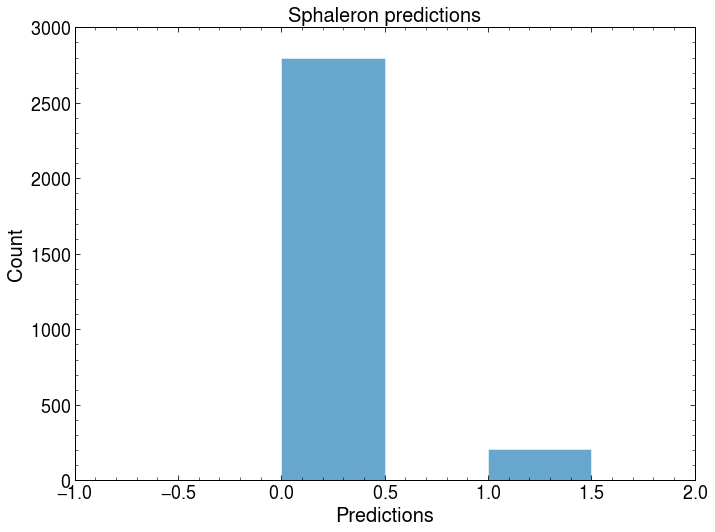

In [7]:
sn.histplot(sph_df_3000["Predictions"], binrange=(-0.5,1.5), binwidth=(0.5))
plt.title("Sphaleron predictions")

Text(0.5, 1.0, 'Black holes predictions')

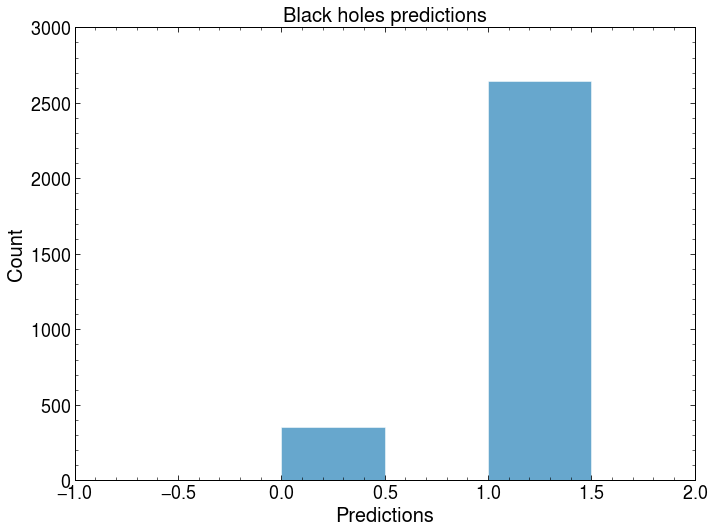

In [8]:
sn.histplot(bh_df_3000["Predictions"], binrange=(-0.5,1.5), binwidth=(0.5))
plt.title("Black holes predictions")

In [9]:
truth, preds = shuffle_predict(model, sph_test_data, CLASSES, 1, RES, DEVICE)
sph_df_shuffled = pd.DataFrame(dict(zip(["Truth", "Predictions"], [truth, preds])))
truth, preds = shuffle_predict(model, bh_test_data, CLASSES, 1, RES, DEVICE)
bh_df_shuffled = pd.DataFrame(dict(zip(["Truth", "Predictions"], [truth, preds])))

100%|██████████| 3000/3000 [00:28<00:00, 104.59it/s]


Text(0.5, 1.0, 'Sphaleron 10 events predictions')

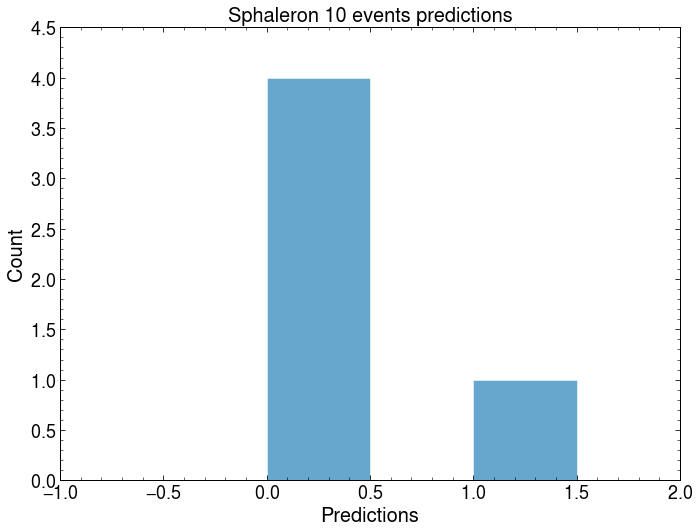

In [193]:
N = 5
k = np.random.randint(0, len(sph_df_shuffled)-N)
sn.histplot(sph_df_shuffled["Predictions"][k:k+N], binrange=(-0.5,1.5), binwidth=(0.5))
plt.title("Sphaleron 10 events predictions")

In [188]:
#chi2 test

def chi2(theory1, theory2, data):
    theory_sph = len(theory1[theory1["Predictions"]==0])/len(theory1)
    theory_bh = len(theory1[theory1["Predictions"]==1])/len(theory1)
    data_sph = len(data[data["Predictions"]==0])/len(data)
    data_bh = len(data[data["Predictions"]==1])/len(data)

    value1 = ((data_sph-theory_sph)**2/theory_sph + (data_bh-theory_bh)**2/theory_bh)
    print(value1)

    theory_sph = len(theory2[theory2["Predictions"]==0])/len(theory2)
    theory_bh = len(theory2[theory2["Predictions"]==1])/len(theory2)
    data_sph = len(data[data["Predictions"]==0])/len(data)
    data_bh = len(data[data["Predictions"]==1])/len(data)

    value2 = ((data_sph-theory_sph)**2/theory_sph + (data_bh-theory_bh)**2/theory_bh)
    print(value2)


N = 7
k = np.random.randint(0, len(sph_df_shuffled)-N)
experiment = bh_df_shuffled[k:k+N]
print(experiment["Predictions"])
chi2(bh_df_3000, sph_df_3000, experiment)


1429    1.0
1430    1.0
1431    1.0
1432    1.0
1433    1.0
1434    0.0
1435    1.0
Name: Predictions, dtype: float32
0.005936791873442565
9.826218899576999
